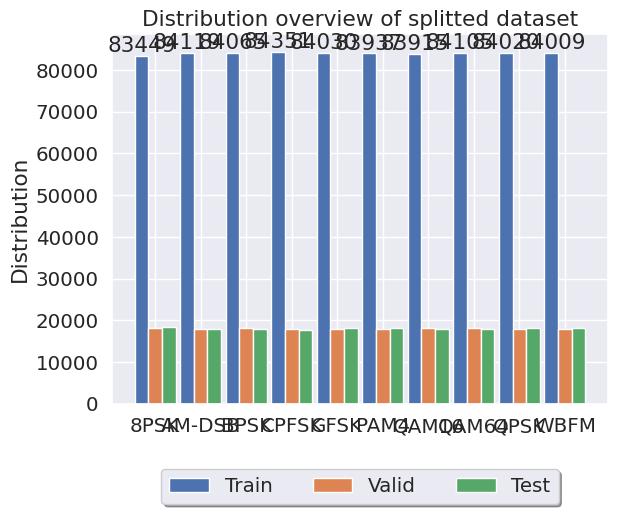

Saved model.json
Epoch 1/2


KeyboardInterrupt: ignored

In [56]:
from scipy.io import loadmat
from pandas import factorize
import pickle
import numpy as np
import random
from scipy import signal

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

def load_dataset(dataset_location):
    """
    Load dataset and extract needed data

    Input:
        dataset_location: specify where the file is stored and its name

    Output:
        snrs: list of the SNR range in dataset [-20 to 18]
        X: array of the measured I/Q data [num_of_samples, 128, 2]
        modulations: list of the modulations in this dataset
        one_hot_encode: one_hot encoded data - the other maps the order of the mods
        lbl_SNR: list of each snr (for plotting)
    """

    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dataset_location.keys())))), [1,0])

    X = []; I = []; Q = []; lbl = [];

    for mod in mods:
        for snr in snrs:
            X.append(dataset_location[(mod,snr)])
            for i in range(dataset_location[(mod,snr)].shape[0]):
                lbl.append((mod,snr))
    X = np.vstack(X); lbl=np.vstack(lbl)

    X = np.transpose(X[:,:,:],(0,2,1))

    # One-hot-encoding
    Y = [];
    for i in range(len(lbl)):
        mod = (lbl[i,0])
        Y.append(mod)

    mapping = {}
    for x in range(len(mods)):
        mapping[mods[x]] = x

    ## integer representation
    for x in range(len(Y)):
        Y[x] = mapping[Y[x]]

    one_hot_encode = to_categorical(Y)

    # Assign SNR value to each vector
    repeat_n = X.shape[0]/len(mods)/len(snrs)
    repeat_n_mod = len(mods)
    lbl_SNR = np.tile(np.repeat(snrs, repeat_n), repeat_n_mod)



    return snrs, X, mods, one_hot_encode, lbl_SNR


def train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15):

    """
    Train-Test split the data

    Input:
        X: X data
        one_hot: Y data encoded to one_hot
        train_split (default 0.7)
        valid_split (default 0.15)
        test_split (default 0.15)
        train_split : valid_split : test_split - ratio for splitting the dataset

        NOTE: the ratio split must be a sum of 1!

    Output:
        train_idx: indexes from X assinged to train data
        valid_idx: indexes from X assinged to validation data
        test_idx: indexes from X assinged to test data
        X_train: X data assigned for training
        X_valid: X data assigned for validation
        X_test: X data assigned for testing
        Y_train: one-hot encoded Y data assigned for training
        Y_valid: one-hot encoded Y data assigned for validation
        Y_test: one-hot encoded Y data assigned for testing
    """

    # Set random seed
    np.random.seed(42)
    random.seed(42)

    # Get the number of samples
    n_examples = X.shape[0]
    n_train = int(n_examples * train_split)
    n_valid = int(n_examples * valid_split)
    n_test = int(n_examples * test_split)

    # Get indexes of train data
    train_idx = np.random.choice(range(0, n_examples), size=n_train, replace=False)

    # Left indexes for valid and test sets
    left_idx= list(set(range(0, n_examples)) - set(train_idx))

    # Get indexes for the left indexes of the X data
    val = np.random.choice(range(0, (n_valid+n_test)), size=(n_valid), replace=False)
    test = list(set(range(0, len(left_idx))) - set(val))

    # Assign indeces for validation to left indexes
    valid_idx = []
    for i in val:
        val_idx = left_idx[i]
        valid_idx.append(val_idx)

    # Get the test set as the rest indexes
    test_idx = []
    for i in test:
        tst_idx = left_idx[i]
        test_idx.append(tst_idx)

    # Shuffle the valid_idx and test_idx
    random.shuffle(valid_idx)
    random.shuffle(test_idx)

    # Assing the indexes to the X and Y data to create train and test sets
    X_train = X[train_idx]
    X_valid = X[valid_idx]
    X_test = X[test_idx]
    Y_train = one_hot[train_idx]
    Y_valid = one_hot[valid_idx]
    Y_test = one_hot[test_idx]

    return train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test


def normalize_data(X_train, X_valid, X_test):
        # mean-std normalization

    mean = X_train[:,:,:].mean(axis=0)
    X_train[:,:,:] -= mean
    std = X_train[:,:,:].std(axis=0)
    X_train[:,:,:] /= std


    X_valid[:,:,:] -= mean
    X_valid[:,:,:] /= std

    X_test[:,:,:] -= mean
    X_test[:,:,:] /= std

    return X_train, X_valid, X_test


def return_indices_of_a(a, b):
    """
    Compare two lists a, b for same items and return indeces
    of the item in list a

    a:    List of items, its indeces will be returned
    b:    List of items to search for in list a"""
    b_set = set(b)
    return [i for i, v in enumerate(a) if v in b_set]


def show_confusion_matrix(validations, predictions, matrix_snr, save=False):
    """
    Plot confusion matrix

    validations:    True Y labels
    predictions:    Predicted Y labels of your model
    matrix_snr:     SNR information for plot's titel
    """

    cm = confusion_matrix(validations, predictions)
    # Normalise
    #cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    c = sns.color_palette("mako_r")
    sns.heatmap(cm, cmap=c, vmin=0, annot=True, fmt='.2f', xticklabels=mods, yticklabels=mods)
    sns.set(font_scale=1.3)
    if matrix_snr == None:
        plt.title("Confusion Matrix")
    else:
        plt.title("Confusion Matrix \n" + str(matrix_snr) + "dB")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    #if save == True:
    #    plt.savefig(base_dir + 'Own_dataset/' + str(matrix_snr) + '.png')
    plt.show(block=False)


def All_SNR_show_confusion_matrix(X_test, save=False):
    """
    Plot confusion matrix of all SNRs in one

    X_test:   X_test data
    """
    prediction = model.predict(X_test)

    Y_Pred = []; Y_Test = [];

    for i in range(len(prediction[:,0])):
        Y_Pred.append(np.argmax(prediction[i,:]))
        Y_Test.append(np.argmax(Y_test[i]))

    show_confusion_matrix(Y_Pred, Y_Test, None, save)


def SNR_show_confusion_matrix(in_snr, lbl_SNR, X_test, save=False):
    """
    Plot confusion matrices of chosen SNRs

    in_snr:   must be list of SNRs
    X_test:   X_test data
    """
    for snr in in_snr:
        matrix_snr = snr
        m_snr = matrix_snr;

        Y_Pred = []; Y_Test = []; Y_Pred_SNR = []; Y_Test_SNR = [];
        matrix_snr_index = [];

        prediction = model.predict(X_test)

        for i in range(len(prediction[:,0])):
            Y_Pred.append(np.argmax(prediction[i,:]))
            Y_Test.append(np.argmax(Y_test[i]))

        for i in range(len(lbl_SNR)):
            if int(lbl_SNR[i]) == m_snr:
                matrix_snr_index.append(i)

        indeces_of_Y_test = return_indices_of_a(test_idx, matrix_snr_index)

        for i in indeces_of_Y_test:
            Y_Pred_SNR.append(Y_Pred[i])
            Y_Test_SNR.append(Y_Test[i])
        show_confusion_matrix(Y_Pred_SNR, Y_Test_SNR, matrix_snr, save)


def plot_split_distribution(mods, Y_train, Y_valid, Y_test):

    x = np.arange(len(mods))  # the label locations
    width = 1  # the width of the bars

    fig, ax = plt.subplots()
    bar1 = ax.bar(x-width*0.3, np.count_nonzero(Y_train == 1, axis=0), width*0.3, label = "Train" )
    bar2 = ax.bar(x , np.count_nonzero(Y_valid == 1, axis=0), width*0.3, label = "Valid" )
    bar3 = ax.bar(x+width*0.3, np.count_nonzero(Y_test == 1, axis=0), width*0.3, label = "Test" )


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Distribution')
    ax.set_title('Distribution overview of splitted dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(mods)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 0),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(bar1)
    #autolabel(bar2)
    #autolabel(bar3)
    # fig.tight_layout()
    return plt.show()


def SNR_accuracy(in_snr, name):
    """
    Computes accuracies of chosen SNRs individualy

    in_snr:   must be list of SNRs
    """

    acc = []
    for snr in in_snr:
        acc_snr = snr
        idx_acc_snr = []

        for i in range(len(test_idx)):
            if int(lbl_SNR[test_idx[i]]) == int(acc_snr):
                idx_acc_snr.append(i)

        acc_X_test = X_test[idx_acc_snr]
        # acc_X_f_test = X_f_test[idx_acc_snr]
        acc_Y_test = Y_test[idx_acc_snr]

        print('\nSNR ' + str(acc_snr) + 'dB:')
        accuracy_snr = model.evaluate([acc_X_test], acc_Y_test, batch_size=32, verbose=2)
        acc.append(accuracy_snr)

    acc = np.vstack(acc)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(SNR, (acc[:,1]*100), 'steelblue', marker='.', markersize= 15, label = name, linestyle = '-',)
    ax.legend(loc=4, prop={'size': 25})

    x_major_ticks = np.arange(-20, 19, 2 )
    ax.set_xticks(x_major_ticks)

    y_major_ticks = np.arange(0, 101, 10 )
    y_minor_ticks = np.arange(0, 101, 2)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)
    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.grid(which='both',color='lightgray', linestyle='-')

    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    plt.xlim(-20, 18)
    plt.ylim(0,100)
    plt.title("Classification Accuracy",fontsize=20)
    plt.ylabel('Accuracy (%)',fontsize=20)
    plt.xlabel('SNR (dB)',fontsize=20)
    # plt.savefig(base_dir + name + '.png')
    plt.show(block=False)

    return acc[:,1]


def layer_overview(model):

    """
    Offers overview of the model's layers and theirs outputs

    model: specify trained model you want to have overview of
    """

    # Names and outputs from layers
    layer_names = [layer.name for layer in model.layers]
    layer_outputs = [layer.output for layer in model.layers[:]]

    return layer_names, layer_outputs

def model_visualization(nth_layer, nth_test_idx, mods, model,
                        plot_sample = False, plot_activations = True,
                        plot_feature_maps = True):

    """
    The function provised overview of activation of specific layer and its
    feature maps.

    nth_layer: enter number which corresponds with the position of wanted layer
    nth_test_idx: enter number pointing at the test indexes from earlier
    mods: provide variable which holds listed modulations
    model: specify which trained model to load
    plot_sample = False: set to true to plot sample data
    plot_activations = True: plots activation of chosen layer
    plot_feature_maps = True: plots feature map of chosen layer
    """

    # Sample data for visualization
    test_sample = X_test[nth_test_idx,:,:] # shape [128,2]
    test_sample = test_sample[None] # change to needed [1,128,2]
    SNR = lbl_SNR[test_idx[nth_test_idx]]
    mod = one_hot[test_idx[nth_test_idx]]
    f, u = factorize(mods)
    mod = mod.dot(f)

    # Names and outputs from layers
    layer_names = [layer.name for layer in model.layers]
    layer_outputs = [layer.output for layer in model.layers[:]]

    ## Activations ##

    # define activation model
    activation_model = tf.keras.models.Model(model.input, layer_outputs)

    # get the activations of chosen test sample
    activations = activation_model.predict(test_sample)

    ## Feature-maps ##

    # define feature maps model
    feature_maps_model = tf.keras.models.Model(model.inputs, model.layers[4].output)

    # get the activated features
    feature_maps = feature_maps_model.predict(test_sample)


    # Plot sample
    if plot_sample == True:
        plt.plot(test_sample[0,:,:])
        plt.title(mod + '    ' + str(SNR) + 'dB')
        plt.show()

    # Plot activations
    if plot_activations == True:
        activation_layer = activations[nth_layer]
        activation_layer = np.transpose(activation_layer[:,:,:],(0,2,1)) # reshape
        fig, ax = plt.subplots(figsize=(20,10))
        ax.matshow(activation_layer[0,:,:],  cmap='viridis')
        # plt.matshow(activation_layer[0,:,:],  cmap='viridis')
        plt.title('Activation map of layer ' + layer_names[nth_layer])
        ax.grid(False)
        ax.set_xlabel('Length of sequence')
        ax.set_ylabel('Filters')
        fig.show()
        #plt.savefig(base_dir + 'activations.png')
        #plt.savefig(base_dir + 'activations.svg')

    # Plot feature maps
    if plot_feature_maps == True:
        n_filters = int(feature_maps.shape[2]/2); ix = 1
        fig = plt.figure(figsize=(30,20))
        for _ in range(n_filters):
            for _ in range(2):
                # specify subplot and turn of axis
                ax =fig.add_subplot(n_filters,  5, ix)
                # ax = plt.subplot(n_filters,  5, ix, )
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                ax.plot(feature_maps[0, :, ix-1])
                ix += 1
        # show the figure
        plt.title('feature maps of layer ' + layer_names[nth_layer])
        fig.show()
        #plt.savefig(base_dir + 'feature_map.png')
        #plt.savefig(base_dir + 'feature_map.svg')


def position_encoding_init(n_position, emb_dim):
    ''' Init the sinusoid position encoding table '''

    # keep dim 0 for padding token position encoding zero vector
    position_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / emb_dim) for j in range(emb_dim)]
        if pos != 0 else np.zeros(emb_dim) for pos in range(n_position)])


    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1

    return position_enc


# Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


dataset_pkl = open("/content/drive/MyDrive/Colab Notebooks/RML2016.10b.dat",'rb')
RML_dataset_location = pickle.load(dataset_pkl, encoding='bytes')

# 10a
SNR, X, modulations, one_hot, lbl_SNR = load_dataset(RML_dataset_location)

mods = []
for i in range(len(modulations)):
    modu = modulations[i].decode('utf-8')
    mods.append(modu)

train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15)
plot_split_distribution(mods, Y_train, Y_valid, Y_test)
# X_train, X_valid, X_test = normalize_data(X_train, X_valid, X_test)

cnn_in = keras.layers.Input(shape=(128,2))
cnn = keras.layers.ZeroPadding1D(padding=4)(cnn_in)
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu')(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu')(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Conv1D(filters=50, kernel_size=4, activation='relu')(cnn)
cnn = keras.layers.Dropout(rate=0.6)(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.GRU(40, return_sequences=True)(cnn)
#cnn = keras.layers.GaussianDropout(0.6)(cnn)
cnn = keras.layers.Flatten()(cnn)
cnn = keras.layers.Dense(70, activation='selu')(cnn)
cnn_out = keras.layers.Dense(len(mods), activation='softmax')(cnn)

model_cnn = keras.models.Model(cnn_in, cnn_out)

model_json = model_cnn.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/model2.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model.json")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/Colab Notebooks/cnn4_model.json", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, min_lr=0.00007),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1)]

optimizer = keras.optimizers.Adam(learning_rate=0.0007)

model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

tf.keras.backend.clear_session()
history = model_cnn.fit(X_train, Y_train, batch_size=128, epochs=2, verbose=2, validation_data= (X_valid, Y_valid), callbacks=callbacks)

model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/cnn4_model.json")

test_loss, test_acc = model.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)
SNR_accuracy(SNR, 'CGRDNN')


model_visualization(1,9000, mods, model)
model_visualization(2,9000, mods, model)
model_visualization(3,9000, mods, model)
model_visualization(9,9000, mods, model)
model_visualization(10,9000, mods, model)
All_SNR_show_confusion_matrix([X_test], save=False)
#SNR_show_confusion_matrix(mods, lbl_SNR[:], X_test, save=False)

In [8]:
pip install hls4ml[profiling]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.9/544.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyparser: filename=pyparser-1.0-py3-none-any.whl size=4913 sha256=f2954b851a385373b28246cc7cec1952eb9a60649fe04d2c5e47e7d5dbdc728f
  Stored in directory: /root/.cache/pip/wheels/25/87/78/ff95e8a747dc534fbd199fb3ea06d80935bc87e44567bbdb31
  Created wheel for parse: filename=parse-1.6.5-py3-none-any.whl size=18155 sha256=a9b

In [30]:
pip install hls4ml

In [51]:
import hls4ml

import json

import qkeras

import hls4ml


def create_config(output_dir='my-hls-test', project_name='myproject', backend='Vivado', **kwargs):

    backend_list = hls4ml.backends.get_available_backends()
    if backend.lower() not in backend_list:
        raise Exception(f'Unknown backend: {backend}')

    backend = hls4ml.backends.get_backend(backend)

    backend_config = backend.create_initial_config(**kwargs)

    config = {}
    config['OutputDir'] = output_dir
    config['ProjectName'] = project_name
    config['Backend'] = backend.name
    config.update(backend_config)

    return config


def _get_precision_from_quantizer(quantizer):

    if isinstance(quantizer, str):
        quantizer_obj = qkeras.get_quantizer(quantizer)
        quantizer = {}
        # Some activations are classes with get_config method
        if hasattr(quantizer_obj, 'get_config'):
            quantizer['class_name'] = quantizer_obj.__class__.__name__
            quantizer['config'] = quantizer_obj.get_config()
        # Some activations are just functions
        else:
            quantizer['class_name'] = quantizer_obj.__name__

    supported_quantizers = [
        'quantized_bits',
        'quantized_relu',
        'quantized_tanh',
        'quantized_sigmoid',
        'quantized_po2',
        'quantized_relu_po2',
        'linear',
    ]
    signed = True
    rnd = "AP_TRN"
    overflow = "AP_WRAP"

    if quantizer['class_name'] in supported_quantizers:
        bits = int(quantizer['config']['bits'])
        # if integer isn't specified, it should be the same as bits
        integer = int(quantizer['config'].get('integer', bits - 1)) + 1
        # for quantizers use the following default rounding and overflow
        rnd = "AP_RND_CONV"
        overflow = "AP_SAT"
        if quantizer['class_name'] in ('quantized_relu', 'quantized_relu_po2'):
            signed = False
            integer -= 1
        elif quantizer['class_name'] == 'quantized_tanh':
            overflow = "AP_SAT_SYM" if quantizer['config']['symmetric'] else "AP_SAT"
            integer = 1
        elif quantizer['class_name'] == 'quantized_sigmoid':
            integer = 0
            signed = False

    elif quantizer['class_name'] in ['binary', 'stochastic_binary', 'binary_tanh']:
        bits = 2
        integer = 2

    elif quantizer['class_name'] in ['ternary', 'stochastic_ternary', 'ternary_tanh']:
        bits = 2
        integer = 2
    else:
        raise Exception('ERROR: Unsupported quantizer: {}'.format(quantizer['class_name']))

    decimal = bits - integer

    if decimal > 0:
        return hls4ml.model.types.FixedPrecisionType(
            width=bits, integer=integer, signed=signed, rounding_mode=rnd, saturation_mode=overflow
        )
    else:
        return hls4ml.model.types.IntegerPrecisionType(width=integer, signed=signed)


def config_from_keras_model1(
    model, granularity='model', backend=None, default_precision='fixed<16,6>', default_reuse_factor=1
):
    """Create an HLS conversion config given the Keras model.

    This function serves as the initial step in creating the custom conversion configuration.
    Users are advised to inspect the returned object to tweak the conversion configuration.
    The return object can be passed as `hls_config` parameter to `convert_from_keras_model`.

    Args:
        model: Keras model
        granularity (str, optional): Granularity of the created config. Defaults to 'model'.
            Can be set to 'model', 'type' and 'name'.

            Granularity can be used to generate a more verbose config that can be fine-tuned.
            The default granularity ('model') will generate config keys that apply to the whole
            model, so changes to the keys will affect the entire model. 'type' granularity will
            generate config keys that affect all layers of a given type, while the 'name' granularity
            will generate config keys for every layer separately, allowing for highly specific
            configuration tweaks.
        backend(str, optional): Name of the backend to use
        default_precision (str, optional): Default precision to use. Defaults to 'fixed<16,6>'.
        default_reuse_factor (int, optional): Default reuse factor. Defaults to 1.

    Raises:
        Exception: If Keras model has layers not supported by hls4ml.

    Returns:
        [dict]: The created config.
    """
    if granularity.lower() not in ['model', 'type', 'name']:
        raise Exception(
            f'Invalid configuration granularity specified, expected "model", "type" or "name" got "{granularity}"'
        )

    if backend is not None:
        backend = hls4ml.backends.get_backend(backend)

    # This is a list of dictionaries to hold all the layer info we need to generate HLS
    layer_list = []

    model_arch = model
    #if isinstance(model, dict):
    #    model_arch = model
    #else:
    #    model_arch = json.loads(model.to_json())

    reader = hls4ml.converters.KerasModelReader(model)

    layer_list, _, _ = parse_keras_model(model_arch, reader)

    def make_layer_config(layer):
        cls_name = layer['class_name']
        if 'config' in layer.keys():
            if 'activation' in layer['config'].keys():
                if layer['config']['activation'] == 'softmax':
                    cls_name = 'Softmax'

        layer_cls = hls4ml.model.layers.layer_map[cls_name]
        if backend is not None:
            layer_cls = backend.create_layer_class(layer_cls)

        layer_config = {}

        config_attrs = [a for a in layer_cls.expected_attributes if a.configurable]
        for attr in config_attrs:
            if isinstance(attr, hls4ml.model.attributes.TypeAttribute):
                precision_cfg = layer_config.setdefault('Precision', {})
                name = attr.name
                if name.endswith('_t'):
                    name = name[:-2]
                if attr.default is None:
                    precision_cfg[name] = default_precision
                else:
                    precision_cfg[name] = str(attr.default)
            else:
                if attr.default is not None:
                    layer_config[attr.config_name] = attr.default

        quantizers = {qname: qclass for qname, qclass in layer.items() if 'quantizer' in qname and qclass is not None}
        for qname, qclass in quantizers.items():
            pname = qname.lower().split('_quantizer')[0]
            if pname == 'activation':
                pname = 'result'
            if isinstance(qclass, dict):
                precision = _get_precision_from_quantizer(qclass)
            else:
                precision = qclass.hls_type
            # TODO In the next version of this function, these should not be exposed to user to tweak
            layer_config['Precision'][pname] = str(precision)

        if layer['class_name'] in ['GarNet', 'GarNetStack']:
            # Define default precisions for various internal arrays (can be overridden from the config file)
            import math

            log2_reuse = int(math.log(default_reuse_factor, 2.0))
            n_vertices_width = int(math.log(layer['n_vertices'], 2.0))

            # We always give 10 digits for the subintegral part
            fwidth = 10
            # Integral precision for aggr_t depends on how large the temporary sum for weighed feature mean will be
            aggr_intw = max(log2_reuse, n_vertices_width - log2_reuse) + 3  # safety factor 2**3
            aggr_w = aggr_intw + fwidth
            # edge_weight_aggr_t does not need the safety factor
            ew_aggr_intw = aggr_intw - 3
            ew_aggr_w = ew_aggr_intw + fwidth

            layer_config['Precision'] = {}
            layer_config['Precision']['edge_weight'] = 'ap_ufixed<10,0,AP_TRN,AP_SAT>'
            layer_config['Precision']['edge_weight_aggr'] = f'ap_ufixed<{ew_aggr_w},{ew_aggr_intw},AP_TRN,AP_SAT>'
            layer_config['Precision']['aggr'] = f'ap_fixed<{aggr_w},{aggr_intw},AP_TRN,AP_SAT>'
            layer_config['Precision']['norm'] = 'ap_ufixed<14,4,AP_TRN,AP_SAT>'

            layer_config['ReuseFactor'] = default_reuse_factor

        elif layer['class_name'] == 'Input':
            dtype = layer['config']['dtype']
            if dtype.startswith('int') or dtype.startswith('uint'):
                typename = dtype[: dtype.index('int') + 3]
                width = int(dtype[dtype.index('int') + 3 :])
                layer_config['Precision']['result'] = f'ap_{typename}<{width}>'
            # elif bool, q[u]int, ...

        return layer_config

    config = {}

    model_config = {}
    model_config['Precision'] = default_precision
    model_config['ReuseFactor'] = default_reuse_factor
    model_config['Strategy'] = 'Latency'
    model_config['BramFactor'] = 1_000_000_000
    model_config['TraceOutput'] = False

    config['Model'] = model_config

    if granularity.lower() == 'type':
        type_config = {}
        for layer in layer_list:
            if layer['class_name'] in type_config:
                continue
            layer_config = make_layer_config(layer)
            type_config[layer['class_name']] = layer_config

        config['LayerType'] = type_config

    elif granularity.lower() == 'name':
        name_config = {}
        for layer in layer_list:
            layer_config = make_layer_config(layer)
            name_config[layer['name']] = layer_config

        config['LayerName'] = name_config

    return config


def config_from_pytorch_model(
    model, granularity='model', backend=None, default_precision='ap_fixed<16,6>', default_reuse_factor=1
):
    """Create an HLS conversion config given the PyTorch model.

    This function serves as the initial step in creating the custom conversion configuration.
    Users are advised to inspect the returned object to tweak the conversion configuration.
    The return object can be passed as `hls_config` parameter to `convert_from_pytorch_model`.

    Args:
        model: PyTorch model
        granularity (str, optional): Granularity of the created config. Defaults to 'model'.
            Can be set to 'model', 'type' and 'layer'.

            Granularity can be used to generate a more verbose config that can be fine-tuned.
            The default granularity ('model') will generate config keys that apply to the whole
            model, so changes to the keys will affect the entire model. 'type' granularity will
            generate config keys that affect all layers of a given type, while the 'name' granularity
            will generate config keys for every layer separately, allowing for highly specific
            configuration tweaks.
        backend(str, optional): Name of the backend to use
        default_precision (str, optional): Default precision to use. Defaults to 'fixed<16,6>'.
        default_reuse_factor (int, optional): Default reuse factor. Defaults to 1.

    Raises:
        Exception: If PyTorch model has layers not supported by hls4ml.

    Returns:
        [dict]: The created config.
    """

    config = {}

    model_config = {}
    model_config['Precision'] = default_precision
    model_config['ReuseFactor'] = default_reuse_factor
    model_config['Strategy'] = 'Latency'

    config['Model'] = model_config

    return config


def config_from_onnx_model(
    model, granularity='model', backend=None, default_precision='ap_fixed<16,6>', default_reuse_factor=1
):
    """Create an HLS conversion config given the ONNX model.

    This function serves as the initial step in creating the custom conversion configuration.
    Users are advised to inspect the returned object to tweak the conversion configuration.
    The return object can be passed as `hls_config` parameter to `convert_from_onnx_model`.

    Args:
        model: ONNX model
        granularity (str, optional): Granularity of the created config. Defaults to 'model'.
            Can be set to 'model', 'type' and 'layer'.

            Granularity can be used to generate a more verbose config that can be fine-tuned.
            The default granularity ('model') will generate config keys that apply to the whole
            model, so changes to the keys will affect the entire model. 'type' granularity will
            generate config keys that affect all layers of a given type, while the 'name' granularity
            will generate config keys for every layer separately, allowing for highly specific
            configuration tweaks.
        backend(str, optional): Name of the backend to use
        default_precision (str, optional): Default precision to use. Defaults to 'fixed<16,6>'.
        default_reuse_factor (int, optional): Default reuse factor. Defaults to 1.

    Raises:
        Exception: If ONNX model has layers not supported by hls4ml.

    Returns:
        [dict]: The created config.
    """

    config = {}

    model_config = {}
    model_config['Precision'] = default_precision
    model_config['ReuseFactor'] = default_reuse_factor
    model_config['Strategy'] = 'Latency'

    config['Model'] = model_config

    return config


    import json

import h5py

from hls4ml.model import ModelGraph

MAXMULT = 4096


class KerasFileReader:
    def __init__(self, config):
        self.config = config
        self.h5file = h5py.File(config['KerasH5'], mode='r')

    def __del__(self):
        if self.h5file:
            self.h5file.close()

    def _find_data(self, layer_name, var_name):
        def h5_visitor_func(name):
            if var_name in name:
                return name

        if 'model_weights' in list(self.h5file.keys()):  # h5 file comes from model.save()
            layer_path = f'model_weights/{layer_name}'
        else:
            layer_path = layer_name

        data_path = self.h5file[layer_path].visit(h5_visitor_func)
        if data_path:
            return self.h5file[f'/{layer_path}/{data_path}']
        else:
            return None

    def get_weights_data(self, layer_name, var_name):
        data = self._find_data(layer_name, var_name)
        if data:
            return data[()]
        else:
            return None

    def get_weights_shape(self, layer_name, var_name):
        data = self._find_data(layer_name, var_name)
        if data is not None:
            return data.shape
        else:
            return None


class KerasModelReader:
    def __init__(self, keras_model):
        self.model = keras_model

    def get_weights_data(self, layer_name, var_name):
        layer = self.model.get_layer(layer_name)
        for i, w in enumerate(layer.weights):
            if var_name in w.name:
                try:
                    return w.numpy()  # TF 2.x
                except Exception:
                    return layer.get_weights()[i]  # TF 1.x

        return None

    def get_weights_shape(self, layer_name, var_name):
        layer = self.model.get_layer(layer_name)
        for w in layer.weights:
            if var_name in w.name:
                return w.shape.as_list()

        return None


layer_handlers = {}


def register_keras_layer_handler(layer_cname, handler_func):
    """Register a handler function for the given layer class name.

    The handler function should have the following signature:
        parse_func(keras_layer, input_names, input_shapes, data_reader, config):

    Args:
        layer_cname (str): The name of Keras layer (the 'class_name' property in the layer's config)
        handler_func (callable): The handler function

    Raises:
        Exception: If the layer class has already been registered.
    """
    if layer_cname in layer_handlers:
        raise Exception(f'Layer {layer_cname} already registered')
    else:
        layer_handlers[layer_cname] = handler_func


def get_supported_keras_layers():
    """Returns the list of Keras layers that the converter can parse.

    The returned list contains all Keras layers that can be parsed into the hls4ml internal representation. Support for
    computation of these layers may vary across hls4ml backends and conversion configuration.

    Returns:
        list: The names of supported Keras layers.
    """
    return list(layer_handlers.keys())


def keras_handler(*args):
    def decorator(function):
        function.handles = [arg for arg in args]
        return function

    return decorator


def parse_default_keras_layer(keras_layer, input_names):
    layer = {}

    # Extract name for finding weights and biases
    layer['name'] = keras_layer['config']['name']
    layer['class_name'] = keras_layer['class_name']
    if input_names is not None:
        layer['inputs'] = input_names

    layer['data_format'] = keras_layer['config'].get('data_format', 'channels_last')

    if 'activation' in keras_layer['config']:
        layer['activation'] = keras_layer['config']['activation']
    if 'epsilon' in keras_layer['config']:
        layer['epsilon'] = keras_layer['config']['epsilon']
    if 'use_bias' in keras_layer['config']:
        layer['use_bias'] = keras_layer['config']['use_bias']

    return layer


def get_model_arch(config):
    if 'KerasModel' in config:
        # Model instance passed in config from API
        keras_model = config['KerasModel']
        if isinstance(keras_model, str):
            from tensorflow.keras.models import load_model

            keras_model = load_model(keras_model)
        model_arch = json.loads(keras_model.to_json())
        reader = KerasModelReader(keras_model)
    elif 'KerasJson' in config:
        # Extract model architecture from json
        with open(config['KerasJson']) as json_file:
            model_arch = json.load(json_file)
        reader = KerasFileReader(config)
    elif 'KerasH5' in config:
        # Model arch and weights are in H5 file (from model.save() function)
        with h5py.File(config['KerasH5'], mode='r') as h5file:
            # Load the configuration from h5 using json's decode
            model_arch = h5file.attrs.get('model_config')
            if model_arch is None:
                raise ValueError('No model found in config file.')
            else:
                # model_arch is string by default since h5py 3.0.0, keeping this condition for compatibility.
                if isinstance(model_arch, bytes):
                    model_arch = model_arch.decode('utf-8')
                model_arch = json.loads(model_arch)
        reader = KerasFileReader(config)
    else:
        raise ValueError('No model found in config file.')

    return model_arch, reader


def parse_keras_model(model_arch, reader):

    # This is a list of dictionaries to hold all the layer info we need to generate HLS
    layer_list = []

    # Define layers to skip for conversion to HLS
    skip_layers = ['Dropout']
    # Activation layers
    activation_layers = [
        'Activation',
        'LeakyReLU',
        'ThresholdedReLU',
        'ELU',
        'PReLU',
        'Softmax',
        'TernaryTanh',
        'HardActivation',
    ]
    # Recurrent layers
    recurrent_layers = ['SimpleRNN', 'LSTM', 'GRU']
    # All supported layers
    supported_layers = get_supported_keras_layers() + skip_layers

    # Map inputs of skipped and split (activation) layers
    inputs_map = {}

    # Loop through layers
    layer_counter = 0

    input_layers = None
    output_layers = None

    layer_config = None

 # TF >= 2.3 calls it 'Funcational' API
    print('Interpreting Model')
    layer_config = model_arch['config']['layers']
    input_layers = [inp[0] for inp in model_arch['config']['input_layers']]
    output_layers = [out[0] for out in model_arch['config']['output_layers']]

    # Get input shape and check for unsupported layer type
    for keras_layer in layer_config:
        if keras_layer['class_name'] not in supported_layers:
            raise Exception('ERROR: Unsupported layer type: {}'.format(keras_layer['class_name']))

    output_shapes = {}
    output_shape = None

    print('Topology:')
    for keras_layer in layer_config:
        if 'batch_input_shape' in keras_layer['config']:
            if 'inbound_nodes' in keras_layer and len(keras_layer['inbound_nodes']) > 0:
                input_shapes = [output_shapes[inbound_node[0]] for inbound_node in keras_layer['inbound_nodes'][0]]
            else:
                input_shapes = [keras_layer['config']['batch_input_shape']]
        else:
            if 'inbound_nodes' in keras_layer:
                input_shapes = [output_shapes[inbound_node[0]] for inbound_node in keras_layer['inbound_nodes'][0]]
            else:
                # Sequential model, so output_shape from the previous layer is still valid
                input_shapes = [output_shape]

        keras_class = keras_layer['class_name']

        if keras_class in skip_layers:
            if 'inbound_nodes' in keras_layer:
                name = keras_layer['config']['name']
                # Currently supported skipped layers have only one input
                parent_input = keras_layer['inbound_nodes'][0][0][0]
                # Skipped layers can follow each other (e.g., Dropout -> Flatten)
                inputs_map[name] = inputs_map.get(parent_input, parent_input)

            output_shapes[keras_layer['config']['name']] = input_shapes[0]

            continue

        if keras_class in supported_layers:
            layer_counter = layer_counter + 1

        # Extract inbound nodes
        if 'inbound_nodes' in keras_layer and len(keras_layer['inbound_nodes']) > 0:
            input_names = [inputs_map.get(inp[0], inp[0]) for inp in keras_layer['inbound_nodes'][0]]
        else:
            input_names = None

        layer, output_shape = layer_handlers[keras_class](keras_layer, input_names, input_shapes, reader)

        print(
            'Layer name: {}, layer type: {}, input shapes: {}, output shape: {}'.format(
                layer['name'], layer['class_name'], input_shapes, output_shape
            )
        )
        layer_list.append(layer)
        if 'activation' in layer and layer['class_name'] not in activation_layers + recurrent_layers:  # + qkeras_layers:
            act_layer = {}
            # Workaround for QKeras activations passed as an argument
            if isinstance(layer['activation'], dict):
                act_details = layer['activation']
                act_layer['class_name'] = 'QActivation'
                act_layer['config'] = {
                    'name': layer['name'] + '_' + act_details['class_name'],
                    'activation': act_details['class_name'],
                }
                act_layer, output_shape = layer_handlers['QActivation'](act_layer, None, [output_shape], reader)
            else:
                act_layer['name'] = layer['name'] + '_' + layer['activation']
                act_layer['activation'] = layer['activation']
                if 'activ_param' in layer:
                    act_layer['activ_param'] = layer['activ_param']
                    act_layer['class_name'] = layer['activation']
                elif layer['activation'] == 'softmax':
                    act_layer['class_name'] = 'Softmax'
                    act_layer['axis'] = -1
                else:
                    act_layer['class_name'] = 'Activation'
            inputs_map[layer['name']] = act_layer['name']
            if output_layers is not None and layer['name'] in output_layers:
                output_layers = [act_layer['name'] if name == layer['name'] else name for name in output_layers]
            layer_list.append(act_layer)

        assert output_shape is not None

        output_shapes[layer['name']] = output_shape

    return layer_list, input_layers, output_layers


def keras_to_hls(config):
    model_arch, reader = get_model_arch(config)
    layer_list, input_layers, output_layers = parse_keras_model(model_arch, reader)
    print('Creating HLS model')
    hls_model = ModelGraph(config, reader, layer_list, input_layers, output_layers)
    return hls_model


#model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/model.json')
t =  open('/content/drive/MyDrive/Colab Notebooks/model.json')
config = config_from_keras_model1(t,granularity='name')
#config = hls4ml.utils.fetch_example_model('KERAS_3layer.json')
  #config = hls4ml.utils.config_from_keras_model(t,granularity='name')
print(t)
hls_model = hls4ml.converters.keras_to_hls(t)
#hls_model = hls4ml.converters.keras_to_hls(config)
#hls4ml.utils.fetch_example_list()

Interpreting Model


TypeError: ignored

Datatype of variable:  <class 'dict'>
class_name Functional
config {'name': 'model_10', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 128, 2], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'ZeroPadding1D', 'config': {'name': 'zero_padding1d', 'trainable': True, 'dtype': 'float32', 'padding': [4, 4]}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 2]}, 'name': 'zero_padding1d', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv1D', 'config': {'name': 'conv1d', 'trainable': True, 'dtype': 'float32', 'filters': 50, 'kernel_size': [8], 'strides': [1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.ini

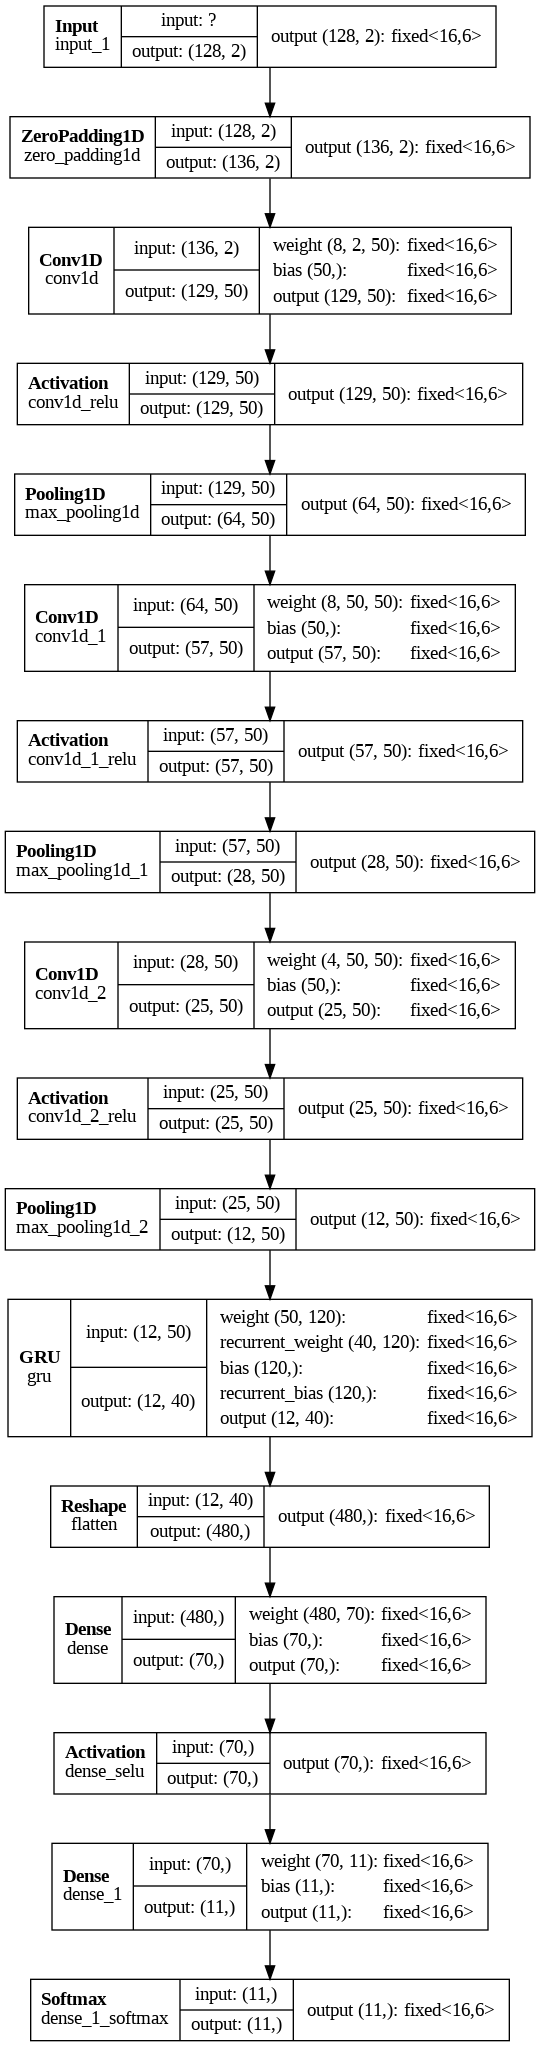

In [73]:
import json
import hls4ml
with open("/content/drive/MyDrive/Colab Notebooks/model2.json","r") as file:
    jsonData = json.load(file)
print("Datatype of variable: ", type(jsonData))
for i in jsonData:
    print(i, jsonData[i])
t = {'OutputDir': '/content/drive/MyDrive/Colab Notebooks/out', 'ProjectName': 'myproject', 'Backend': 'Vivado', 'Part': 'xcku115-flvb2104-2-i', 'ClockPeriod': 5, 'IOType': 'io_parallel', 'HLSConfig': {'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1}}, 'KerasJson': '/content/drive/MyDrive/Colab Notebooks/model2.json', 'KerasH5': '/content/drive/MyDrive/Colab Notebooks/cnn3_model.h5'}
#config = hls4ml.utils.config_from_keras_model(jsonData,granularity='name')
print(t)
hls_model = hls4ml.converters.keras_to_hls(t)
hls4ml.utils.plot_model(hls_model,show_precision=True,show_shapes=True,to_file=None)

#from hls4ml.model import profiling
#hls_model_std = hls4ml.converters.convert_from_keras_model(jsonData,hls_config=t,output_dir='/content/drive/MyDrive/Colab Notebooks/out',part='xcku115-flvb2104-2-i')

In [65]:
import hls4ml
config = hls4ml.utils.fetch_example_model('KERAS_3layer.json')

# You can print the configuration to see some default parameters
print(config)

# Convert it to a hls project
hls_model = hls4ml.converters.keras_to_hls(config)


{'OutputDir': 'my-hls-test', 'ProjectName': 'myproject', 'Backend': 'Vivado', 'Part': 'xcku115-flvb2104-2-i', 'ClockPeriod': 5, 'IOType': 'io_parallel', 'HLSConfig': {'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1}}, 'KerasJson': 'KERAS_3layer.json', 'KerasH5': 'KERAS_3layer_weights.h5'}
Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1_relu, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: fc2_relu, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: fc3_relu, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output_softmax, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Creating HLS model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
